In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import glob
import os

import pickle

OMNIGLOT_DATA = os.path.join(os.getcwd(), 'omniglot/')
DATASET_DIR = os.path.join(os.getcwd(), 'omniglot_search/')

import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 12.0)
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import dataset_utils

from joblib import Parallel, delayed

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>")) 

### Create config file

In [2]:
config = dataset_utils.DatasetGeneratorConfig()

### Load Omniglot Dataset

In [3]:
def reorder_glots(glots):
    reordered_glots=[]
    for alph in range(len(glots)):
        for char in range(len(glots[alph])):
            reordered_glots.append(glots[alph][char])
    
    return reordered_glots

#Load glots from pickle file
path = OMNIGLOT_DATA

#Train split
with open(path + 'glots_train.pickle', 'rb') as fp:
    glots_train = pickle.load(fp)
    glots_train = reorder_glots(glots_train)
    
#Evaluation split
with open(path + 'glots_eval.pickle', 'rb') as fp:
    glots_eval = pickle.load(fp)
    glots_eval = reorder_glots(glots_eval)
    
#Test split
with open(path + 'glots_test.pickle', 'rb') as fp:
    glots_test = pickle.load(fp)
    glots_test = reorder_glots(glots_test)

### Dataset Generation Script

In [6]:
checksums = [[b'}\x82\x8e\xc1\xe46W\x88\xf9yxQ\x9f{\xa7\x95', 
              b'\xcbM\xd09\x80\x13\xfa\xe2<R\x9a\xe3\x85\xbb\x9aQ', 
              b'I\xc6p}\x8b\x1a\xc8!K\xd5\xe8\x12\x9a\xe6\x07J', 
              b'\xd9Q0\xd6\x15\xe6kv\x12S\xef\x01Z\xca\xb8&'], 
             [b"\x06M\xef\x9e\xcb\xe0\xee\x19S'5\xdaVK6q", 
              b'm\x7f\xdd\x00aG]\x9d\xd9\xa7\xb2Jc\xb9\x8a\x86', 
              b'\xbb\x1f\xaf\xdc\xcdO\xfd\xa1Y\t\xce\x1e\t\x8d\xbc\x8d', 
              b'l9J\xd0\xe1\xdb&\xa7\x89\xd1\xb5\x0c\x9dGmu'], 
             [b'\x92{)\xb7\x11\xd0\xe4\x8f\xef\xf1\xf2\xde\x08\xfd\xecd', 
              b'\x1e\xdd^&G\xf1\x95f5|\xaf\xb7\xfa\xa8&\xeb', 
              b'\xccZ\x93\x999\xab\xa2\xb5\x13\x8d&J\xe6\xae\x90\xa4', 
              b'}8~a;\xc4\xe6ij\xcb\x91s>\x19L\x90'], 
             [b'\xd1\xfc\xa3\xb5\xc3Z\xcf\xb4\x82\x8f\t]\xcf\x1dr\x00', 
              b'\xf0\xc0_/"O\x9f\xfe\xc0[l\x10}R1\x00', 
              b'\x02\xc3\xd6v\xec\xe3\xb2\x1c{~\xc8\xb0\x06\xb5\xa3\x8f', 
              b'\x13\x80!\xba\x06\xccZ\xda\x81\x08{\xb1\xdc\xaa>\xe2'], 
             [b'X\x9d\xccYH\xab\xd3\xc1Jy\x07Z\\\x8a\xf0\xe8', 
              b',\xa99\xfaQ\xc7xMa\x84{\x99\x9c\xd0\xf4\xf1', 
              b'\x8c\x80uP\xf7\xc0\xd1\x08\x9f\x80\x90@\n;\x91\xb5', 
              b"k\xd8\x7f\xc2\t'\xfc\xa5\x8b\x1a\x90U[::w"], 
             [b'9h6#\x12}\x8d\\\x97T\xbb7h\xb7\xc9\xed', 
              b'4U\x0fr\xd1"E\xabP\xd7\xcb\xa6\xf6#\x17Y', 
              b'\xbbp\x1e\xd0\x8eX\x8f\xc2\x01^<\xb82\xa7@<', 
              b'\x8cp\x83\xdb\x93\xdd?N\xf5\xd8\xbat*\x95#\x9a'], 
             [b"Y7\x82\xbf\x17\xe5\x9f\x89[\xc0dX\xe3\x8d'm", 
              b'\xf8\x0bF\x82f\x9f\x0eM\x8d\x9c\xa0\xc5\x91\xc8\xb1\xb4', 
              b'\xaa\xcb\xb6\x1f\x0b\xdbzD\xa8\xde\xfd<9\xd2\x98\xe6', 
              b'\xb8\x7fi\x8aB\xa7VU\xd6\x8ey\x7f?\x15\\\x03']]

In [7]:
# Generate indicidual datasets for each clutter level
nname =  [4, 8, 16, 32, 64, 128, 256]
nchars = [3, 7, 15, 31, 63, 127, 255]
# Generate one dataset for all clutter levels
# nname =  ['mix']
# nglots = [[3, 7, 15, 31, 63, 127, 255]]

for i in range(len(nname)):
    # Set and print saving directory
    dset_dir = DATASET_DIR + '{}_characters/'.format(nname[i])
    print('')
    print(dset_dir)

    # Set number of images per parallel job
    config.JOBLENGTH = 2000
    # Set number of distractors
    config.DISTRACTORS = nchars[i]
    
    ### Generate training set ###
    
    # Set dataset split
    config.DRAWER_SPLIT = 'train'
    # Define number of train images
    dataset_size = 2000000
    # Choose training alphabets
    glots = glots_train
    # Set path
    path = dset_dir + 'train/'
    # Set a fixed seed
    seed_train = 2209944264

    # Generate dataset
    #dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_train, save=True)


    ### Generate evaluation and test sets ###

    # Set dataset split
    config.DRAWER_SPLIT = 'val'
    # Define number of val/test images
    dataset_size = 10000

    #Generate evaluation set on train characters
    seed_val_train = 4020197800
    glots = glots_train
    path = dset_dir + 'val-train/'
    print('Generating dataset val-train/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_val_train, save=True, checksum=checksums[i][0])
    print('')
    
    #Generate test set on train characters
    seed_test_train = 1665765955
    glots = glots_train
    path = dset_dir + 'test-train/'
    print('Generating dataset val-train/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_test_train, save=True, checksum=checksums[i][1])
    print('')

    #Generate evaluation set on one-shot characters
    seed_val_one_shot = 3755213170
    glots = glots_eval
    path = dset_dir + 'val-one-shot/'
    print('Generating dataset val-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_val_one_shot, save=True, checksum=checksums[i][2])
    print('')

    #Generate test set on one-shot characters
    seed_test_one_shot = 2301871561
    glots = glots_test
    path = dset_dir + 'test-one-shot/'
    print('Generating dataset test-one-shot/')
    dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=seed_test_one_shot, save=True, checksum=checksums[i][3])
    print('')

print('')
print('All Done')


/gpfs01/bethge/home/cmichaelis/datasets/omniglot_search/4_characters/
Generating dataset val-train/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    9.2s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.5s finished
12.244265079498291
b'}\x82\x8e\xc1\xe46W\x88\xf9yxQ\x9f{\xa7\x95'
Cluttered Omniglot was correctly created!

Generating dataset val-train/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.7s remaining:   11.6s
[Parallel(n_jobs=-1)]: Done  

29.394279718399048
b'\xd1\xfc\xa3\xb5\xc3Z\xcf\xb4\x82\x8f\t]\xcf\x1dr\x00'
Cluttered Omniglot was correctly created!

Generating dataset val-train/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.1s remaining:   39.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   26.7s remaining:   17.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.2s finished
28.796674489974976
b'\xf0\xc0_/"O\x9f\xfe\xc0[l\x10}R1\x00'
Cluttered Omniglot was correctly created!

Generating dataset val-one-shot/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.9s rem

183.4650251865387
b'\xf8\x0bF\x82f\x9f\x0eM\x8d\x9c\xa0\xc5\x91\xc8\xb1\xb4'
Cluttered Omniglot was correctly created!

Generating dataset val-one-shot/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.7min remaining:  4.1min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  2.7min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.8min finished
169.78415298461914
b'\xaa\xcb\xb6\x1f\x0b\xdbzD\xa8\xde\xfd<9\xd2\x98\xe6'
Cluttered Omniglot was correctly created!

Generating dataset test-one-shot/
Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   2 out of   5 | 

### Dataset Visualization Script

Executing 5 tasks
Seed fixed
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.9s remaining:    5.9s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    5.3s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.4s finished


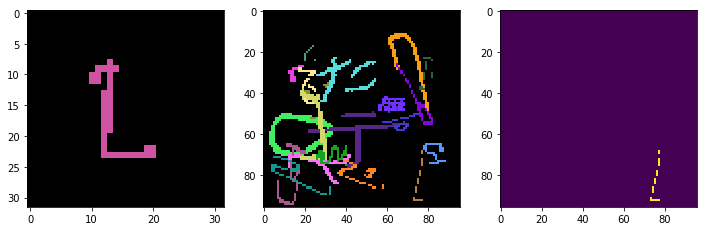

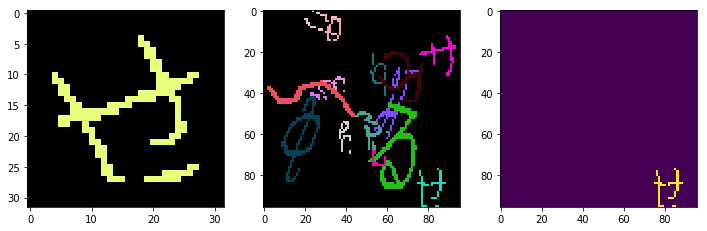

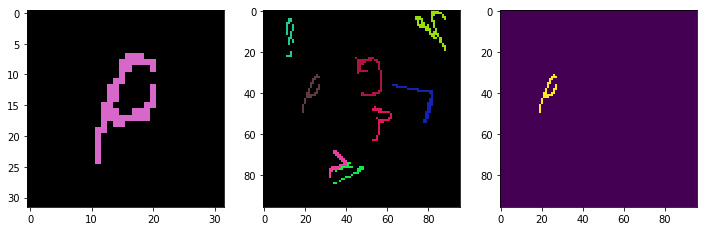

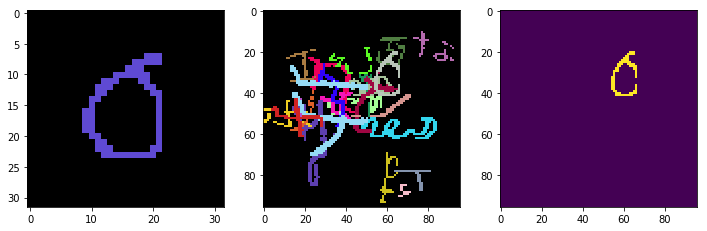

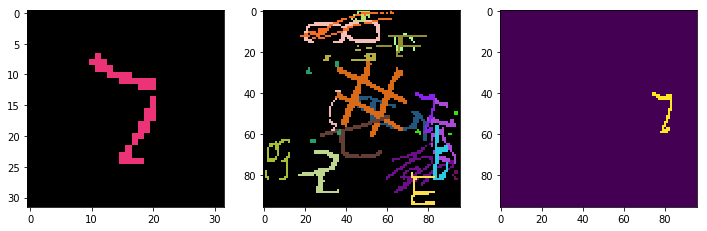

11.993953943252563
b'\xfa\xaa\xe4G\xa9\xa5\txG\xf4J\x00\x81\x8aXX'
Cluttered Omniglot was correctly created!


In [41]:
#Show some random example images

# Define number of images
dataset_size = 5

# Choose training alphabets
glots = glots_train
# Set number of images per parallel job
config.JOBLENGTH = 1
# Set number of distractors
config.DISTRACTORS = 31
# Set dataset split
config.DRAWER_SPLIT = 'train'

# set path if images should be saved
dset_dir = DATASET_DIR + '{}_characters/'.format(config.DISTRACTORS + 1)
path = DATASET_DIR + 'visualize/'

# Run visualization
dataset_utils.generate_dataset(path, dataset_size, glots, config, seed=None, save=False, show=True)